# Imports

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rtree
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib_scalebar.scalebar import ScaleBar

import rasterio
import rasterio.plot

import matplotlib.pylab as pl
from matplotlib import rc

## Figure Formatting

In [2]:
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')

fo = "#73956F"
pr = "#F37748"
we = "#336699"
nd = "#52154E"
ep = "#EADEDA"

fs = 20
lts = 15
#https://coolors.co/eadeda-f37748-73956f-336699-52154e


ymax = 2876500
ymin = 2837400

xmax = 694500
xmin = 667500

## Preprocessing

In [3]:
parcels = gpd.read_file("data/parcels.shp")

towns = gpd.read_file("data/townssurvey_shp/TOWNSSURVEY_POLY.shp")
towns.head()

f = towns[towns["TOWN"] == "FRANKLIN"]

In [4]:
x = parcels[["area_x","CH61_TYPE"]].groupby("CH61_TYPE").sum()
x["area_a"] = x["area_x"]/4046.8564224
x

area_x      area_a
CH61_TYPE                          
61A        2.116066e+06  522.891208
61B        2.632945e+06  650.614817

In [5]:
parcels = parcels[parcels["t_as_val_x"]>0]

npp = parcels[(parcels["LEV_PROT"] != "P") & (parcels["LEV_PROT"] != "T")& 
              (parcels["LEV_PROT"] != "L") & (parcels["LEV_PROT"] != "N") & (parcels["LEV_PROT"] != "X")]
npp = npp[npp['t_as_val_x']>0]
npp = npp[(npp["owner1_x"]!="FRANKLIN TOWN OF") & (npp["owner1_x"]!="FRANKLIN  TOWN OF")]



pp =parcels[(parcels["LEV_PROT"] == "P") | (parcels["LEV_PROT"] == "T")|
            (parcels["LEV_PROT"] == "L") | (parcels["LEV_PROT"]== "N") | (parcels["LEV_PROT"] == "X") |
            (parcels["owner1_x"] == "FRANKLIN TOWN OF") | (parcels["owner1_x"]=="FRANKLIN  TOWN OF")] #| ~(parcels["CH61_TYPE"].isna())]


#bound_list = []
#for i in npp.index:
#    for j in pp.index:
#            geom1 = npp.loc[i]['geometry']
#            geom2 = pp.loc[j]['geometry']
#            geom_new = geom1.intersection(geom2)
#            #print(j)
#            if geom_new.length>0:
#                bound_list += [[i, j, 1]]

#bound = pd.DataFrame(bound_list, columns=['npp', 'pp', 'boundary'])
#bound.to_csv("boundaries.csv")

bound = pd.read_csv("boundaries.csv")
npp = npp.join(bound.set_index("npp"), how = "left")

npp.loc[npp["boundary"].isna(), "boundary"] = 0

In [6]:
pp["area_a"] = pp["area_x"]/4046.8564223999238

C:\Users\RoseDeterman\anaconda3\envs\gis3\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [7]:
x = parcels.agg(total_area=pd.NamedAgg(column='area_x', aggfunc='sum'),
            priha_area=pd.NamedAgg(column='priha_m2', aggfunc='sum'),
            fores_area=pd.NamedAgg(column='for_m2', aggfunc='sum'),
            wetla_area=pd.NamedAgg(column='wet_m2', aggfunc='sum'),
            devel_area=pd.NamedAgg(column='dev_m2', aggfunc='sum'))

x/4046.8564223999238

area_x   priha_m2      for_m2       wet_m2       dev_m2
total_area  15555.025376        NaN         NaN          NaN          NaN
priha_area           NaN  219.24702         NaN          NaN          NaN
fores_area           NaN        NaN  8100.31925          NaN          NaN
wetla_area           NaN        NaN         NaN  2489.912261          NaN
devel_area           NaN        NaN         NaN          NaN  4087.366314

In [8]:
pp.groupby('LEV_PROT').agg(area=pd.NamedAgg(column='area_a', aggfunc='sum'))

area
LEV_PROT             
L          292.057921
N          306.311385
P         4336.077839
X           21.093114

## Create Functions

In [9]:
def outcomes(scenario, selected_parcels, metric_area, scenario_df):
    dm_select = selected_parcels
    
    
    
    
    n = len(dm_select.index)
    area_t= sum(dm_select['area_x'])/4046.85642
    
    metric_a = sum(dm_select[metric_area])/4046.85642#total area of avoided forest loss in hectare
    budget = sum(dm_select['t_as_val_x']) #total cost for the conservation easements in $, assuming that the indicated price is paid 
    
    #avg_usd_metric = budget/metric_a
    
    x= dm_select[["boundary", "area_x"]].groupby(['boundary']).sum()
    x["per_land"] = round(x["area_x"]/sum(x["area_x"]) *100, 2)
    per_bound = x.loc[1]["per_land"]
     
    x= dm_select[["CH61_TYPE", "area_x"]].groupby(['CH61_TYPE'], dropna = False).sum()
    x["per_land"] = round(x["area_x"]/sum(x["area_x"]) *100, 2)
    per_nch61 = x.loc[x.index.isnull()]["per_land"]
    if per_nch61.empty:
        per_ch61 = 100
    else:
        per_ch61= 100 - per_nch61.iloc[0]
    
    summary =pd.DataFrame({"scenario": [scenario],
                          "n": [n], 
                          "area_acre": [area_t],
                          "metric_area_acre": [metric_a],
                          "budget": [budget], 
                          "per_bound_prot": [per_bound],
                          "per_ch61": [per_ch61]})
   #                       "cost per metric": [avg_usd_metric]})
    
    if scenario_df.empty:
        return(summary)
    else:
        return(scenario_df.append(summary))

In [10]:
BUDGET = 1000000

def priority_parcels(df, metric): #sort ascending
    npp = df
    #sort based on metric (low to high)
    npp = npp.sort_values(by=metric)
    #replace inf values with nan and drop
    npp[metric].replace([np.inf, -np.inf], np.nan, inplace=True)
    # Drop rows with NaN
    #npp.dropna(inplace=True)
    npp = npp[~npp["MAP_PAR_ID"].duplicated()]

    #calculate cummulative sum of parcel cost
    npp['ce_cost_pred_usd_sum'] = npp['t_as_val_x'].cumsum()
    npp = npp[~npp["MAP_PAR_ID"].duplicated()]
    #select parcels less than budget
    i=npp['ce_cost_pred_usd_sum'].lt(BUDGET)
    
    #return dataframe of selected parcels
    return(npp[i])

def priority_parcels2(df, metric):  #sort descending
    npp = df
    #sort based on metric (low to high)
    npp = npp.sort_values(by=metric,ascending=False )
    #replace inf values with nan and drop
    #npp[metric].replace([np.inf, -np.inf], np.nan, inplace=True)
    
    
    # Drop rows with NaN
    #npp.dropna(inplace=True)
    npp = npp[~npp["MAP_PAR_ID"].duplicated()]
    npp = npp[npp["t_as_val_x"] < BUDGET]

    #calculate cummulative sum of parcel cost
    npp['ce_cost_pred_usd_sum'] = npp['t_as_val_x'].cumsum()
    npp = npp[~npp["MAP_PAR_ID"].duplicated()]
    #select parcels less than budget
    i=npp['ce_cost_pred_usd_sum'].lt(BUDGET)
    
    #return dataframe of selected parcels
    return(npp[i])



def review(df):
    cols = ["MAP_PAR_ID", "CH61_TYPE", "st_name_x", "owner1_x", "boundary"]
    return(df[cols])
  
    
def plot_scenarios(relev_parcels, opt, large, inexpensive, color, title, save_name):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey="row")

    #inputs: all relevant parcels, select parcels (opt, large, inexpensive), color
    #        first title, save name

    #Plot 1: All relevant space
    pp.plot(ax = ax1, color = ep)
    relev_parcels.plot(ax = ax1, color = color)
    f.plot(ax = ax1, color = "#00000000", edgecolor = "black")
    ax1.axis('off')
    ax1.set_title(title,fontsize=fs)

    #Plot 2: Optimal Allocation
    pp.plot(ax = ax2, color = ep)
    opt.plot(ax = ax2, color = color)
    f.plot(ax = ax2, color = "#00000000", edgecolor = "black")
    ax2.axis('off')
    ax2.set_title("Optimal Selection",fontsize=fs)

    #Plot 3: Largest Parcels
    pp.plot(ax = ax3, color = ep)
    large.plot(ax = ax3, color = color)
    f.plot(ax = ax3, color = "#00000000", edgecolor = "black")
    ax3.axis('off')
    ax3.set_title("Largest Parcels",fontsize=fs)

    #Plot 4: Least Expensive Parcels
    pp.plot(ax = ax4, color = ep)
    inexpensive.plot(ax = ax4, color = color)
    f.plot(ax = ax4, color = "#00000000", edgecolor = "black")
    ax4.axis('off')
    ax4.set_title("Least Expensive Parcels",fontsize=fs)

    #create legend
    handles = [Patch(facecolor=ep,label='Existing Protected Areas'),
               Patch(facecolor=color,label=title)]

    ax1.legend(handles=handles,bbox_to_anchor=(0,-0.15), fontsize = lts, loc="lower left")

    
    fig.set_size_inches(20, 20/1.618)
    savename = "figures/" + save_name
    plt.savefig(savename, bbox_inches='tight')

# Overview Maps

## State

In [11]:
#roads = gpd.read_file("data/roads/CENSUS2010TIGERROADS_ARC.shp")
#roads=gpd.clip(roads, f)
#roads.to_file("data/roads/roads_clip.shp")
roads = gpd.read_file("data/roads/roads_clip.shp")

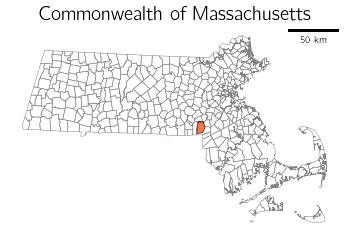

In [12]:
fig, ax = plt.subplots()
towns.plot(ax=ax, color='none', edgecolor='gray', linewidth = 0.5)
f.plot(ax=ax, color=pr, edgecolor='black', linewidth = 0.5)
ax.axis('off')
ax.add_artist(ScaleBar(1))
#fig.set_size_inches(19/1.618, 19)
ax.set_title("Commonwealth of Massachusetts",fontsize=fs)
plt.savefig('figures/state.png', bbox_inches='tight')

## Developed Area

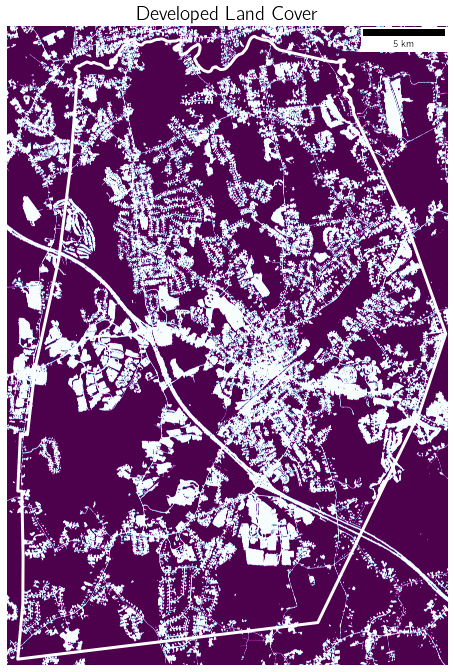

In [13]:
raster = rasterio.open("data/2016_HighResLandCover/developed.tif")

fig, ax = plt.subplots()
rasterio.plot.show(raster, ax=ax, cmap = "BuPu_r")

f.to_crs(raster.crs).plot(ax=ax, color='none', edgecolor='white', linewidth = 3)

ax.add_artist(ScaleBar(1))
ax.set_title("Developed Land Cover",fontsize=fs)
plt.xlim(xmax=xmax, xmin=xmin)
plt.ylim(ymax=ymax, ymin=ymin)

ax.axis('off')
fig.set_size_inches(19,19/1.618)
plt.savefig('figures/developed.png', bbox_inches='tight')

## Tax Value

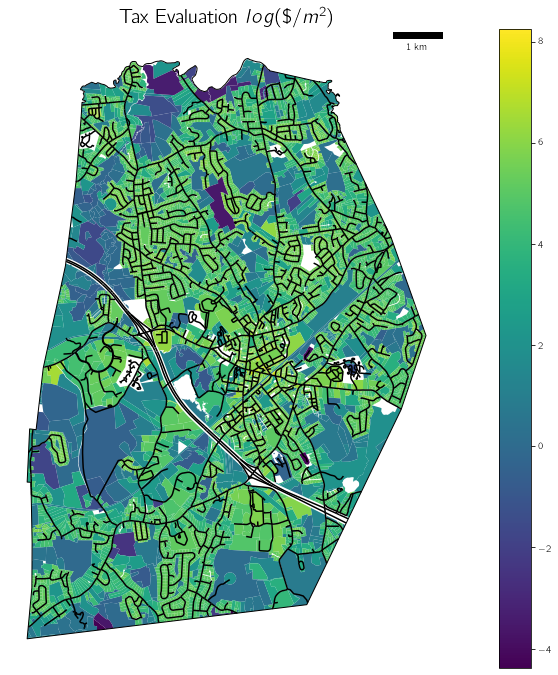

In [14]:
parcels["log_val_per_ar"] = np.log(parcels["val_per_ar"])

fig, ax = plt.subplots()

#parcels[(parcels["LEV_PROT"] == "P")].plot(color = ep, ax = ax)

parcels.plot("log_val_per_ar",cmap = "viridis", 
             ax = ax, legend= True,
              )

roads.plot(ax = ax, color = "black")

f.plot(ax=ax, color='none', edgecolor='black')

ax.add_artist(ScaleBar(1))
ax.set_title("Tax Evaluation $log (\$/m^2)$",fontsize=fs)

ax.axis('off')
fig.set_size_inches(19,19/1.618)

plt.savefig('figures/landval.png', bbox_inches='tight')

## Existing Protected Areas and Ch 61

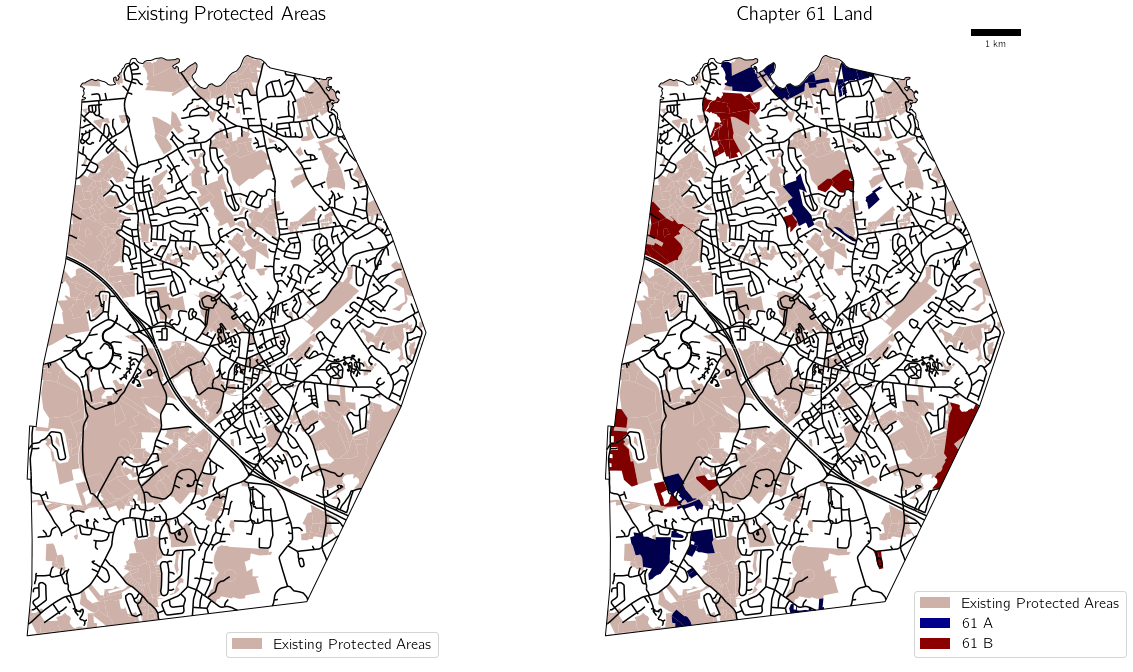

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey="row")

#plot existing protected space
pp.plot(color = "#ceb2a9", ax = ax1)
ax1.set_title("Existing Protected Areas",fontsize=fs)

#plot town outline
f.plot(ax=ax1, color='none', edgecolor='black')
roads.plot(ax = ax1, color = "black")


#create legend
handles = [Patch(facecolor="#ceb2a9", label='Existing Protected Areas') ]
ax1.legend(handles=handles, fontsize=lts, loc='lower right')

ax1.axis('off')


pp.plot(color = "#ceb2a9", ax = ax2)
parcels[~parcels["CH61_TYPE"].isna()].plot("CH61_TYPE",ax = ax2, legend = True, 
                                          cmap = "seismic")

#parcels.plot("mean_dev",cmap = "viridis", ax = ax, legend= True)
roads.plot(ax = ax2, color = "black")

f.plot(ax=ax2, color='none', edgecolor='black')
ax2.add_artist(ScaleBar(1))
#ax.add_artist(ScaleBar(1))
ax2.set_title("Chapter 61 Land",fontsize=fs)

handles = [Patch(facecolor="#ceb2a9", label='Existing Protected Areas'),
           Patch(facecolor = "darkblue", label = "61 A"),
           Patch(facecolor = "darkred", label = "61 B")]
ax2.legend(handles=handles,bbox_to_anchor=(1.25,0), fontsize=lts, loc='lower right')
ax2.axis('off')

fig.set_size_inches(19,19/1.618)

plt.savefig('figures/existing_prot.png', bbox_inches='tight')

## Town Owned Land

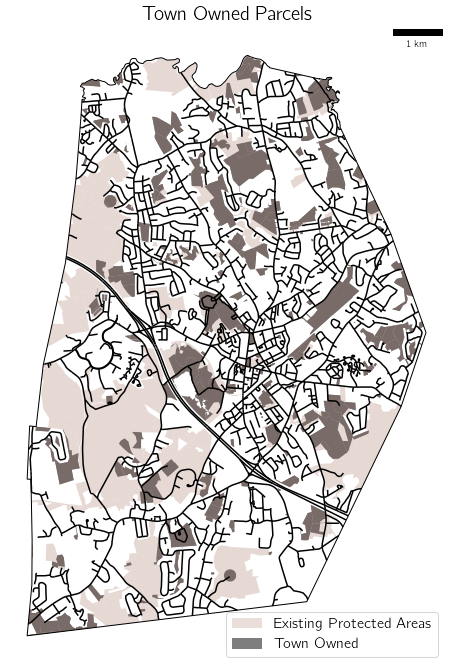

In [16]:
fig, ax1 = plt.subplots()

ax1.set_title("Town Owned Parcels",fontsize=fs)

#plot existing protected space
parcels[parcels["owner1_x"] =="FRANKLIN TOWN OF"].plot(color = "black", alpha = 0.85, ax = ax1)
pp.plot(color = "#ceb2a9", alpha = 0.5, ax = ax1)


#plot town outline
f.plot(ax=ax1, color='none', edgecolor='black')
roads.plot(ax = ax1, color = "black")

#create legend
handles = [Patch(facecolor=ep, label='Existing Protected Areas'),
           Patch(facecolor="black",alpha = 0.5, label='Town Owned')]
ax1.legend(handles=handles, fontsize=lts, loc='lower right')

ax1.axis('off')


ax1.add_artist(ScaleBar(1))
ax1.axis('off')

fig.set_size_inches(19,19/1.618)

plt.savefig('figures/town_owned_land.png', bbox_inches='tight')

# Priority Habitat

In [17]:
out = pd.DataFrame()

In [18]:
npp_pr = npp[npp["priha_m2"]>0]

#optimal allocation
npp_pr_op = priority_parcels(npp_pr,"cost_priha")
out = outcomes("Opt. Priority Habitat", npp_pr_op, "priha_m2", out)

#largest parcels
npp_pr_lg = priority_parcels2(npp_pr,"priha_m2")
out = outcomes("Largest Priority Habitat", npp_pr_lg, "priha_m2", out)

#least expensive
npp_pr_le = priority_parcels(npp_pr,"t_as_val_x")
out = outcomes("Least expensive Priority Habitat", npp_pr_le, "priha_m2", out)

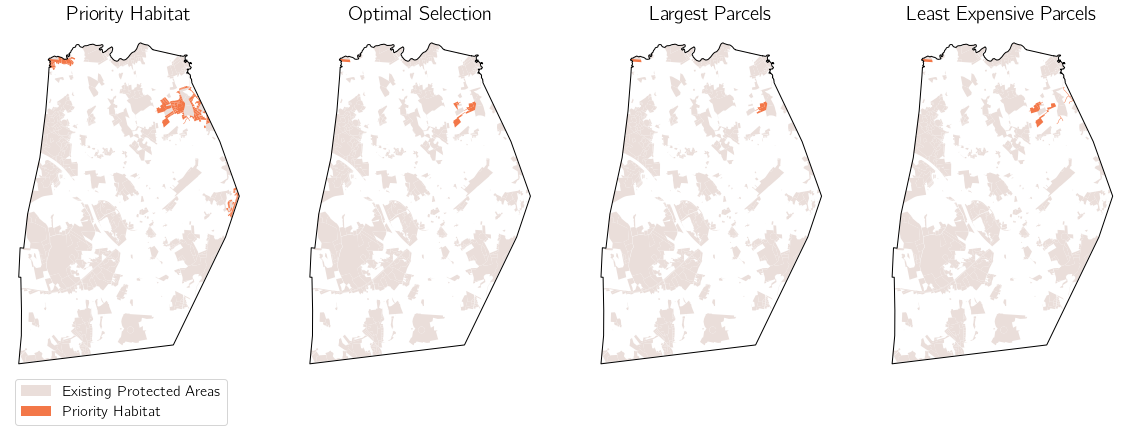

In [19]:
plot_scenarios(npp_pr, npp_pr_op,npp_pr_lg, npp_pr_le, pr, "Priority Habitat", "prihab.png" )

# Forest Cover

In [20]:
npp_forest = npp[npp["for_m2"]>=4046.8564224]

#optimal allocation
npp_fo_op = priority_parcels(npp_forest,"cost_for_m")
out = outcomes("Opt. Forest", npp_fo_op, "for_m2", out)

#largest parcels
npp_fo_lg = priority_parcels2(npp_forest,"for_m2")
out = outcomes("Largest Forest", npp_fo_lg, "for_m2", out)

#least expensive
npp_fo_le = priority_parcels(npp_forest,"t_as_val_x")
out = outcomes("Least expensive Forest", npp_fo_le, "for_m2", out)

In [21]:
review(npp_fo_op)

MAP_PAR_ID CH61_TYPE             st_name_x  \
9904  348-002-000-000       61A         WASHINGTON ST   
8022  302-023-001-000      None           LAWRENCE DR   
94    206-033-000-000       61A           KOSHIVAS DR   
93    206-032-000-000       61A           KOSHIVAS DR   
95    206-034-000-000       61A           KOSHIVAS DR   
8997  326-001-000-000       61A         WASHINGTON ST   
9877  343-022-001-000       61A               VINE ST   
494   212-026-000-000       61B               POND ST   
1382  222-046-000-000       61B               POND ST   
8351  308-076-000-000       61B           PROSPECT ST   
1383  222-047-000-000       61B               POND ST   
1869  229-003-002-000       61A      HOFFMANN FARM RD   
1390  222-054-000-000       61B               POND ST   
1812  227-015-000-000       61B            LINCOLN ST   
8999  326-003-000-000       61A         WASHINGTON ST   
29    204-005-000-000       61A            LINCOLN ST   
5853  270-020-000-000      None   OLD WEST CENTRAL ST   
6629  281-006-000-000      None          PEAR TREE LN   
542   213-045-000-000       61B               POND ST   
5854  270-021-000-000      None  FRANKLIN CROSSING RD   
1399  222-063-000-000       61B          PARTRIDGE ST   
3669  248-070-000-000      None           PLEASANT ST   
9559  338-033-000-000      None           PROSPECT ST   

                            owner1_x  boundary  
9904              COOK WARREN HOWARD       1.0  
8022        DELLORCO ENTERPRISES LLC       0.0  
94                KOSHIVAS CHARLES J       0.0  
93                KOSHIVAS CHARLES J       0.0  
95                KOSHIVAS CHARLES J       0.0  
8997                  COOK MARILYN E       1.0  
9877          MORSE PETER W ETAL TRS       0.0  
494                  LEMBO GAIL V TR       0.0  
1382                 LEMBO GAIL V TR       1.0  
8351                      HENO FLOYD       1.0  
1383                 LEMBO GAIL V TR       0.0  
1869              HOFFMAN NICHOLAS F       0.0  
1390                 LEMBO GAIL V TR       0.0  
1812                CALNAN JOHN W JR       1.0  
8999                  COOK MARILYN E       0.0  
29                     KOSHIVOS JOHN       0.0  
5853           LEDGEWOOD CONDOMINIUM       1.0  
6629      CHESTNUT RIDGE CONDO ASSOC       0.0  
542                  LEMBO GAIL V TR       1.0  
5854   FRANKLIN CROSSING CONDOMINIUM       1.0  
1399                 LEMBO GAIL V TR       1.0  
3669  PRIDE REAL ESTATE DEV. CORP TR       0.0  
9559            THAYER ROSS & ROBERT       1.0

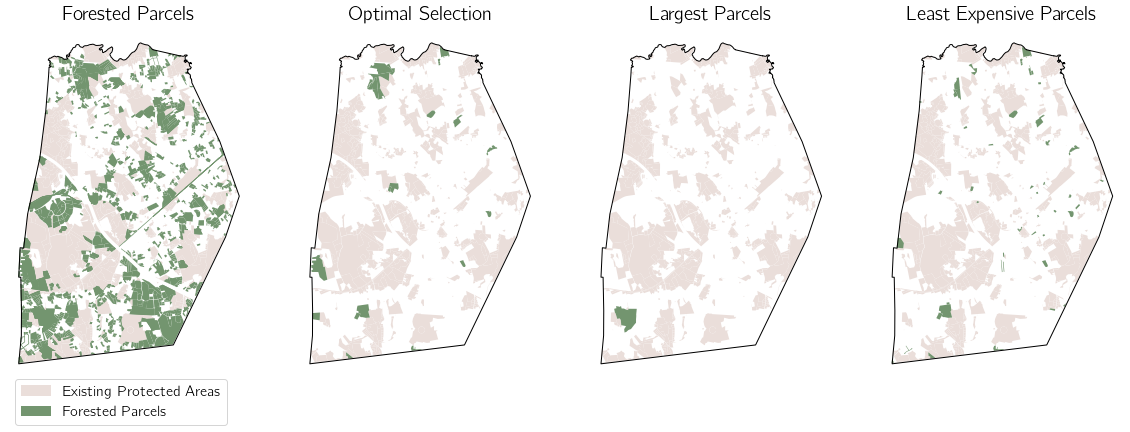

In [22]:
plot_scenarios(npp_forest, npp_fo_op,npp_fo_lg, npp_fo_le, fo, "Forested Parcels", "forest.png" )

# Wetlands

In [23]:
npp_wet = npp[npp["wet_m2"]>=4046.8564224]

#optimal allocation
npp_we_op = priority_parcels(npp_wet,"cost_wet_m")
out = outcomes("Opt. Wetlands", npp_we_op, "wet_m2", out)

#largest parcels
npp_we_lg = priority_parcels2(npp_wet,"wet_m2")
out = outcomes("Largest Wetlands", npp_we_lg, "wet_m2", out)

#least expensive
npp_we_le = priority_parcels(npp_wet,"t_as_val_x")
out = outcomes("Least expensive Wet", npp_we_le, "wet_m2", out)

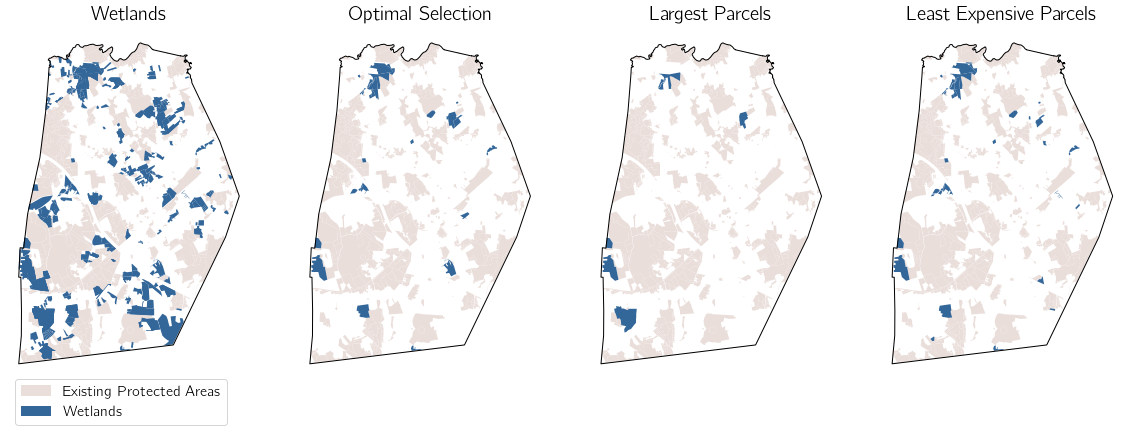

In [24]:
plot_scenarios(npp_wet, npp_we_op,npp_we_lg, npp_we_le, we, "Wetlands", "wetland.png" )

# Undeveloped Land

In [25]:
npp_ndev = npp[((npp["ndev_m2"] > 4046.8564224) & (npp["mean_dev"] <= 0.5))]

#optimal allocation
npp_nd_op = priority_parcels(npp_ndev,"cost_ndev_")
out = outcomes("Opt. Non-Dev", npp_nd_op, "ndev_m2", out)

#largest parcels
npp_nd_lg = priority_parcels2(npp_ndev,"wet_m2")
out = outcomes("Largest Non-Dev", npp_nd_lg, "ndev_m2", out)

#least expensive parcels
#parcels = ascending 
#parcesl2 = descending

npp_nd_le = priority_parcels(npp_ndev,"t_as_val_x")
out = outcomes("Least expensive Non-Dev", npp_nd_le, "ndev_m2", out)

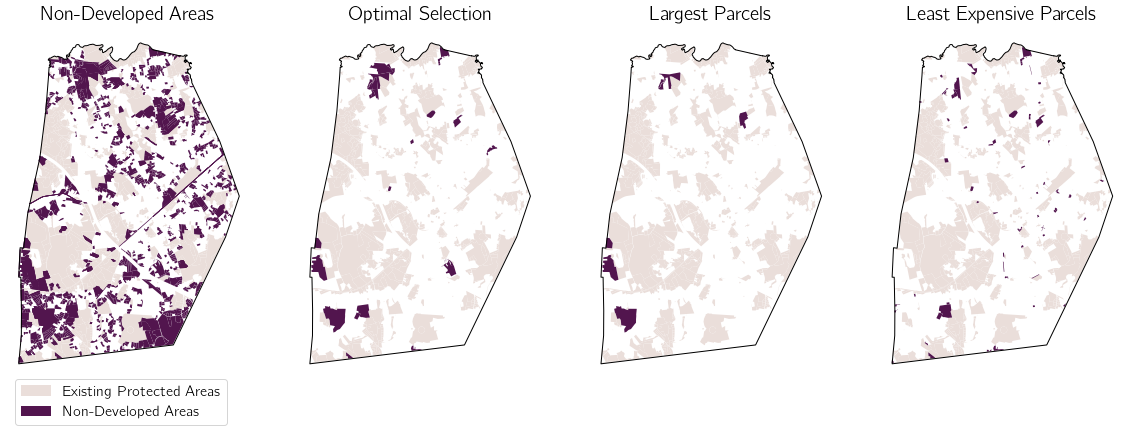

In [26]:
plot_scenarios(npp_ndev, npp_nd_op,npp_nd_lg, npp_nd_le, nd, "Non-Developed Areas", "ndev.png" )

# AT RISK PARCELS

# Results

In [27]:
out

scenario   n   area_acre  metric_area_acre  \
0             Opt. Priority Habitat   9   53.761495         32.937837   
0          Largest Priority Habitat   3   30.298416         27.216150   
0  Least expensive Priority Habitat  13   64.345478         23.315936   
0                       Opt. Forest  23  396.378231        224.381223   
0                    Largest Forest   1  114.101253         63.197404   
0            Least expensive Forest  51  260.962662        146.315652   
0                     Opt. Wetlands  26  427.810753        177.202954   
0                  Largest Wetlands   5  282.531762         96.106370   
0               Least expensive Wet  33  386.394996        153.367195   
0                      Opt. Non-Dev  25  511.944128        495.109572   
0                   Largest Non-Dev   5  282.531762        280.471921   
0           Least expensive Non-Dev  64  237.817814        234.470357   

     budget  per_bound_prot  per_ch61  
0  943696.0           53.10     28.81  
0  839200.0           74.54      0.00  
0  984796.0           57.89     24.07  
0  573684.0           61.60     83.86  
0  431590.0          100.00    100.00  
0  968075.0           40.65     67.50  
0  921384.0           67.49     72.06  
0  741653.0          100.00     89.31  
0  969184.0           63.25     79.79  
0  910547.0           70.48     90.08  
0  741653.0          100.00     89.31  
0  975934.0           41.82     67.85

# Exclude Ch 61 land

In [28]:
parcels = parcels[parcels["CH61_TYPE"].isna()]

npp = parcels[(parcels["LEV_PROT"] != "P") & (parcels["LEV_PROT"] != "T")& 
              (parcels["LEV_PROT"] != "L") & (parcels["LEV_PROT"] != "N") & (parcels["LEV_PROT"] != "X")]
npp = npp[npp['t_as_val_x']>0]
npp = npp[(npp["owner1_x"]!="FRANKLIN TOWN OF") & (npp["owner1_x"]!="FRANKLIN  TOWN OF")]
npp = npp[~npp["MAP_PAR_ID"].duplicated()]


pp =parcels[(parcels["LEV_PROT"] == "P") | (parcels["LEV_PROT"] == "T")|
            (parcels["LEV_PROT"] == "L") | (parcels["LEV_PROT"]== "N") | (parcels["LEV_PROT"] == "X") |
            (parcels["owner1_x"] == "FRANKLIN TOWN OF") | (parcels["owner1_x"]=="FRANKLIN  TOWN OF")] #| ~(parcels["CH61_TYPE"].isna())]
pp = pp[~pp["MAP_PAR_ID"].duplicated()]


#bound_list = []
#for i in npp.index:
#    for j in pp.index:
#            geom1 = npp.loc[i]['geometry']
#            geom2 = pp.loc[j]['geometry']
#            geom_new = geom1.intersection(geom2)
            #print(j)
#            if geom_new.length>0:
#                bound_list += [[i, j, 1]]

#bound = pd.DataFrame(bound_list, columns=['npp', 'pp', 'boundary'])
#bound.to_csv("boundaries_n61.csv")


bound = pd.read_csv("boundaries_n61.csv")
npp = npp.join(bound.set_index("npp"), how = "left")
npp.loc[npp["boundary"].isna(), "boundary"] = 0

MAP_PAR_ID CH61_TYPE         st_name_x               owner1_x  \
1952  230-034-000-000      None         MILLER ST           MARGOLIS LEE   
1870  229-003-003-000      None  HOFFMANN FARM RD     HOFFMAN NICHOLAS F   
1868  229-003-001-000      None  HOFFMANN FARM RD     HOFFMAN NICHOLAS F   
1863  228-042-001-000      None        DANIELS ST      RAFFERTY  KEVIN B   
2076  232-060-000-000      None       MULBERRY LN    RAFFERTY KEVIN B TR   
1005  218-077-000-000      None     SILVER FOX RD       MAPLE SANDS CORP   
1861  228-041-001-000      None        DANIELS ST      RAFFERTY  KEVIN B   
1857  228-038-000-000      None        LINCOLN ST       K B REALTY TRUST   
1890  229-022-001-000      None        DANIELS ST    SMITSVILLE FARM LLC   
294   210-007-000-000      None          PLAIN ST  BOSTON EDISON COMPANY   
1891  229-023-000-000      None        DANIELS ST    SMITSVILLE FARM LLC   
1892  229-024-000-000      None        DANIELS ST         NEWCOMB PAUL D   

      boundary  
1952       0.0  
1870       0.0  
1868       0.0  
1863       0.0  
2076       1.0  
1005       1.0  
1861       1.0  
1857       1.0  
1890       0.0  
294        1.0  
1891       0.0  
1892       0.0

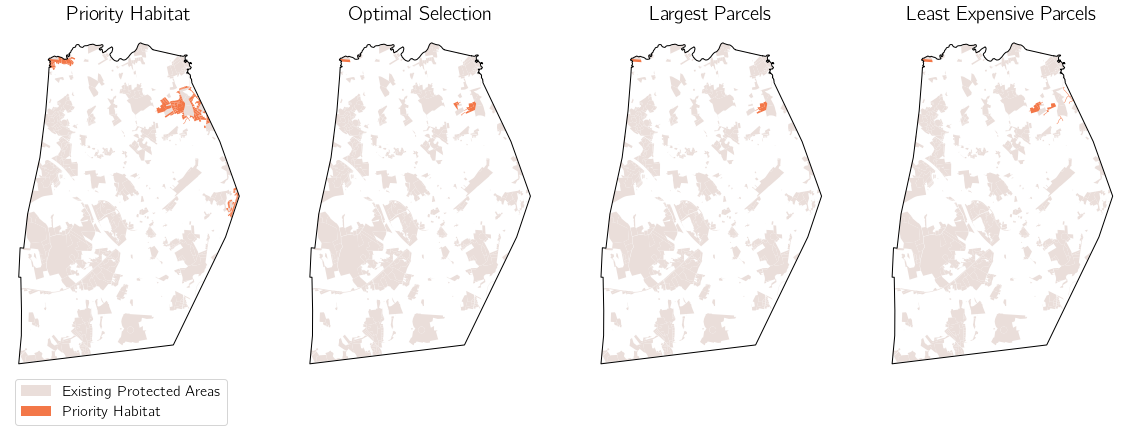

In [29]:
# Priority Habitat
npp_pr = npp[npp["priha_m2"]>0]

#optimal allocation
npp_pr_op = priority_parcels(npp_pr,"cost_priha")
out = outcomes("No Ch.61- Opt. Priority Habitat", npp_pr_op, "priha_m2", out)

#largest parcels
npp_pr_lg = priority_parcels2(npp_pr,"priha_m2")
out = outcomes("No Ch.61-Largest Priority Habitat", npp_pr_lg, "priha_m2", out)

#least expensive
npp_pr_le = priority_parcels(npp_pr,"t_as_val_x")
out = outcomes("No Ch.61-Least expensive Priority Habitat", npp_pr_le, "priha_m2", out)

plot_scenarios(npp_pr, npp_pr_op,npp_pr_lg, npp_pr_le, pr, "Priority Habitat", "n_61prihab.png" )
review(npp_pr_op)
review(npp_pr_lg)
review(npp_pr_le)

MAP_PAR_ID CH61_TYPE             st_name_x  \
8022  302-023-001-000      None           LAWRENCE DR   
5853  270-020-000-000      None   OLD WEST CENTRAL ST   
6629  281-006-000-000      None          PEAR TREE LN   
5854  270-021-000-000      None  FRANKLIN CROSSING RD   
3669  248-070-000-000      None           PLEASANT ST   
9559  338-033-000-000      None           PROSPECT ST   
8941  324-011-000-000      None           PROSPECT ST   
8505  314-011-000-000      None              UNION ST   
9912  349-007-000-000      None         WASHINGTON ST   
5349  266-100-001-000      None           CHESTNUT ST   
1846  227-050-000-000      None            HANCOCK RD   
4125  251-113-000-000      None              MAPLE ST   
8075  303-045-000-000      None        SPRUCE POND RD   
1857  228-038-000-000      None            LINCOLN ST   
9549  338-023-001-000      None            CYPRESS LN   
6079  277-013-000-000      None       WEST CENTRAL ST   
5354  267-004-001-000      None           PLEASANT ST   
3056  242-027-000-000      None         KIMBERLEE AVE   

                             owner1_x  boundary  
8022         DELLORCO ENTERPRISES LLC       0.0  
5853            LEDGEWOOD CONDOMINIUM       1.0  
6629       CHESTNUT RIDGE CONDO ASSOC       0.0  
5854    FRANKLIN CROSSING CONDOMINIUM       1.0  
3669   PRIDE REAL ESTATE DEV. CORP TR       0.0  
9559             THAYER ROSS & ROBERT       1.0  
8941        CROOKS MARCIA A & DIANA C       1.0  
8505                 MERCER GARY E TR       1.0  
9912                   LAMB BARBARA S       1.0  
5349  YERGATIAN CHARLES & JULIA B TRS       0.0  
1846                      HILL SARA A       0.0  
4125                     DEAN COLLEGE       1.0  
8075              SPRUCE POND VILLAGE       1.0  
1857                 K B REALTY TRUST       1.0  
9549       MARINELLA CONSTRUCTION INC       1.0  
6079            BOSTON OIL CHANGE LLC       1.0  
5354                  KNAPP KENNETH R       0.0  
3056           FITZGERALD LORENA R TR       0.0

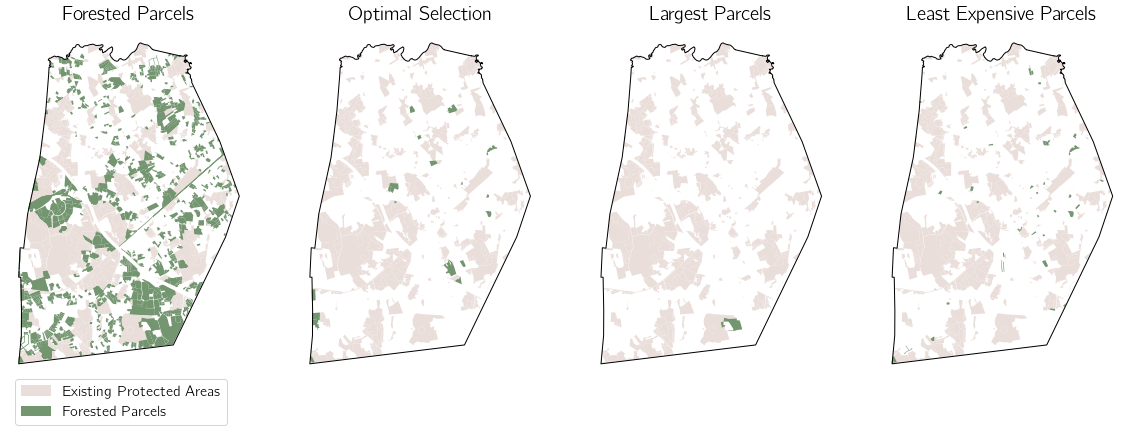

In [30]:
# Forest Cover

npp_forest = npp[npp["for_m2"]>=4046.8564224]

#optimal allocation
npp_fo_op = priority_parcels(npp_forest,"cost_for_m")
out = outcomes("No Ch.61-Opt. Forest", npp_fo_op, "for_m2", out)

#largest parcels
npp_fo_lg = priority_parcels2(npp_forest,"for_m2")
out = outcomes("No Ch.61-Largest Forest", npp_fo_lg, "for_m2", out)

#least expensive
npp_fo_le = priority_parcels(npp_forest,"t_as_val_x")
out = outcomes("No Ch.61-Least expensive Forest", npp_fo_le, "for_m2", out)

plot_scenarios(npp_forest, npp_fo_op,npp_fo_lg, npp_fo_le, fo, "Forested Parcels", "n_61forest.png" )
review(npp_fo_op)

MAP_PAR_ID CH61_TYPE        st_name_x  \
3044  242-015-000-000      None         MAPLE ST   
2150  233-034-001-000      None       LINCOLN ST   
4279  253-035-000-000      None          POND ST   
1365  222-028-009-000      None          NINA LN   
1351  222-022-000-000      None         BEECH ST   
3669  248-070-000-000      None      PLEASANT ST   
5910  271-025-000-000      None  WEST CENTRAL ST   
8075  303-045-000-000      None   SPRUCE POND RD   
2153  233-037-000-000      None       LINCOLN ST   
6551  280-007-000-000      None      CHESTNUT ST   
5951  272-009-000-000      None  WEST CENTRAL ST   
1863  228-042-001-000      None       DANIELS ST   
462   211-150-000-000      None     MARY ANNE DR   
6657  281-028-000-000      None      CHESTNUT ST   
1861  228-041-001-000      None       DANIELS ST   
190   208-001-000-000      None          POND ST   
1857  228-038-000-000      None       LINCOLN ST   
8469  313-054-000-000      None          KING ST   

                            owner1_x  boundary  
3044                    DERRICO JOEL       0.0  
2150                    NOEL LINDA L       0.0  
4279                 RONDEAU ROGER A       1.0  
1365                  ZODA TRACI-LEE       1.0  
1351                   VFW POST 3402       0.0  
3669  PRIDE REAL ESTATE DEV. CORP TR       0.0  
5910             MARTIN WILLIAM C TR       1.0  
8075             SPRUCE POND VILLAGE       1.0  
2153         BASSIGNANI WILLIAM C JR       1.0  
6551               WHITMAN HOMES INC       0.0  
5951         FORGE PARK REALTY TRUST       0.0  
1863               RAFFERTY  KEVIN B       0.0  
462                  CHILSON JAMES C       1.0  
6657            DELFINO RICHARD P TR       0.0  
1861               RAFFERTY  KEVIN B       1.0  
190            BOSTON EDISON COMPANY       1.0  
1857                K B REALTY TRUST       1.0  
8469          MINE BROOK CORPORATION       0.0

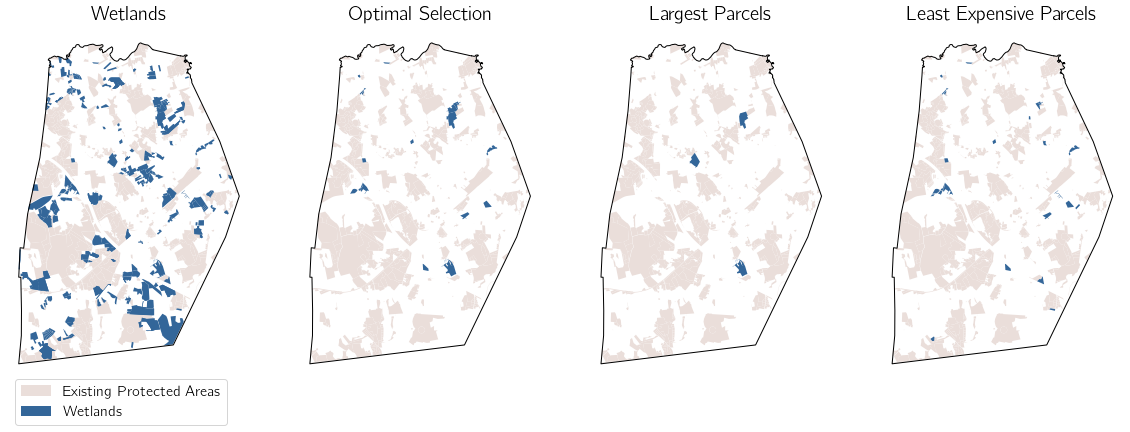

In [37]:
# Wetlands

npp_wet = npp[npp["wet_m2"]>=4046.8564224]

#optimal allocation
npp_we_op = priority_parcels(npp_wet,"cost_wet_m")
out = outcomes("No Ch.61-Opt. Wetlands", npp_we_op, "wet_m2", out)

#largest parcels
npp_we_lg = priority_parcels2(npp_wet,"wet_m2")
out = outcomes("No Ch.61-Largest Wetlands", npp_we_lg, "wet_m2", out)

#least expensive
npp_we_le = priority_parcels(npp_wet,"t_as_val_x")
out = outcomes("No Ch.61-Least expensive Wet", npp_we_le, "wet_m2", out)

plot_scenarios(npp_wet, npp_we_op,npp_we_lg, npp_we_le, we, "Wetlands", "n_61wetland.png" )
review(npp_we_op)

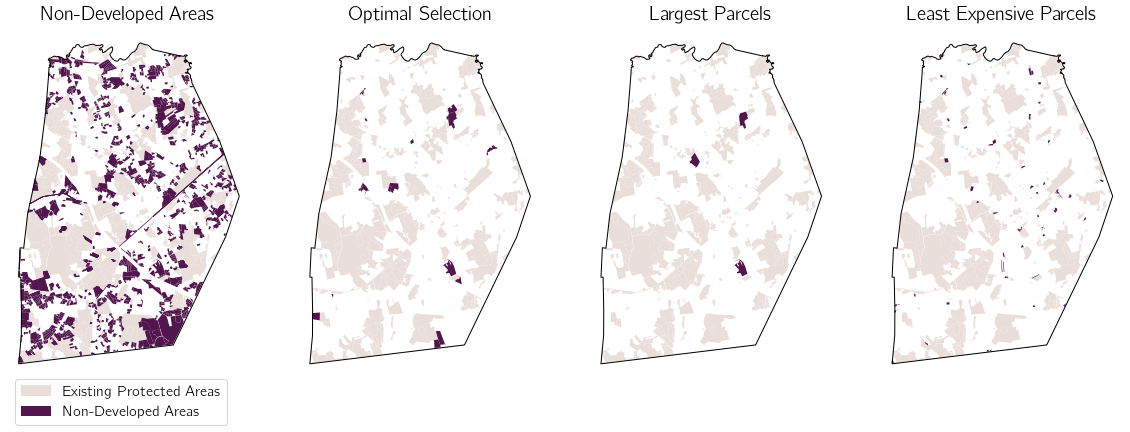

In [32]:
# Undeveloped Land

npp_ndev = npp[((npp["ndev_m2"] > 4046.8564224) & (npp["mean_dev"] <= 0.5))]

#optimal allocation
npp_nd_op = priority_parcels(npp_ndev,"cost_ndev_")
out = outcomes("No Ch.61-Opt. Non-Dev", npp_nd_op, "ndev_m2", out)

#largest parcels
npp_nd_lg = priority_parcels2(npp_ndev,"wet_m2")
out = outcomes("No Ch.61-Largest Non-Dev", npp_nd_lg, "ndev_m2", out)

#least expensive parcels
#parcels = ascending 
#parcesl2 = descending

npp_nd_le = priority_parcels(npp_ndev,"t_as_val_x")
out = outcomes("No Ch.61-Least expensive Non-Dev", npp_nd_le, "ndev_m2", out)

plot_scenarios(npp_ndev, npp_nd_op,npp_nd_lg, npp_nd_le, nd, "Non-Developed Areas", "n_61ndev.png" )

In [36]:
review(npp_fo_op)

MAP_PAR_ID CH61_TYPE             st_name_x  \
8022  302-023-001-000      None           LAWRENCE DR   
5853  270-020-000-000      None   OLD WEST CENTRAL ST   
6629  281-006-000-000      None          PEAR TREE LN   
5854  270-021-000-000      None  FRANKLIN CROSSING RD   
3669  248-070-000-000      None           PLEASANT ST   
9559  338-033-000-000      None           PROSPECT ST   
8941  324-011-000-000      None           PROSPECT ST   
8505  314-011-000-000      None              UNION ST   
9912  349-007-000-000      None         WASHINGTON ST   
5349  266-100-001-000      None           CHESTNUT ST   
1846  227-050-000-000      None            HANCOCK RD   
4125  251-113-000-000      None              MAPLE ST   
8075  303-045-000-000      None        SPRUCE POND RD   
1857  228-038-000-000      None            LINCOLN ST   
9549  338-023-001-000      None            CYPRESS LN   
6079  277-013-000-000      None       WEST CENTRAL ST   
5354  267-004-001-000      None           PLEASANT ST   
3056  242-027-000-000      None         KIMBERLEE AVE   

                             owner1_x  boundary  
8022         DELLORCO ENTERPRISES LLC       0.0  
5853            LEDGEWOOD CONDOMINIUM       1.0  
6629       CHESTNUT RIDGE CONDO ASSOC       0.0  
5854    FRANKLIN CROSSING CONDOMINIUM       1.0  
3669   PRIDE REAL ESTATE DEV. CORP TR       0.0  
9559             THAYER ROSS & ROBERT       1.0  
8941        CROOKS MARCIA A & DIANA C       1.0  
8505                 MERCER GARY E TR       1.0  
9912                   LAMB BARBARA S       1.0  
5349  YERGATIAN CHARLES & JULIA B TRS       0.0  
1846                      HILL SARA A       0.0  
4125                     DEAN COLLEGE       1.0  
8075              SPRUCE POND VILLAGE       1.0  
1857                 K B REALTY TRUST       1.0  
9549       MARINELLA CONSTRUCTION INC       1.0  
6079            BOSTON OIL CHANGE LLC       1.0  
5354                  KNAPP KENNETH R       0.0  
3056           FITZGERALD LORENA R TR       0.0

In [35]:
out.to_csv("results.csv")
out

scenario   n   area_acre  \
0                      Opt. Priority Habitat   9   53.761495   
0                   Largest Priority Habitat   3   30.298416   
0           Least expensive Priority Habitat  13   64.345478   
0                                Opt. Forest  23  396.378231   
0                             Largest Forest   1  114.101253   
0                     Least expensive Forest  51  260.962662   
0                              Opt. Wetlands  26  427.810753   
0                           Largest Wetlands   5  282.531762   
0                        Least expensive Wet  33  386.394996   
0                               Opt. Non-Dev  25  511.944128   
0                            Largest Non-Dev   5  282.531762   
0                    Least expensive Non-Dev  64  237.817814   
0            No Ch.61- Opt. Priority Habitat   8   38.272860   
0          No Ch.61-Largest Priority Habitat   3   30.298416   
0  No Ch.61-Least expensive Priority Habitat  12   48.856843   
0                       No Ch.61-Opt. Forest  18  180.252137   
0                    No Ch.61-Largest Forest   1   46.929997   
0            No Ch.61-Least expensive Forest  40  100.824484   
0                     No Ch.61-Opt. Wetlands  18  161.647663   
0                  No Ch.61-Largest Wetlands   3   89.430871   
0               No Ch.61-Least expensive Wet  24  111.021319   
0                      No Ch.61-Opt. Non-Dev  18  201.845822   
0                   No Ch.61-Largest Non-Dev   3   89.430871   
0           No Ch.61-Least expensive Non-Dev  54   88.744995   

   metric_area_acre    budget  per_bound_prot  per_ch61  
0         32.937837  943696.0           53.10     28.81  
0         27.216150  839200.0           74.54      0.00  
0         23.315936  984796.0           57.89     24.07  
0        224.381223  573684.0           61.60     83.86  
0         63.197404  431590.0          100.00    100.00  
0        146.315652  968075.0           40.65     67.50  
0        177.202954  921384.0           67.49     72.06  
0         96.106370  741653.0          100.00     89.31  
0        153.367195  969184.0           63.25     79.79  
0        495.109572  910547.0           70.48     90.08  
0        280.471921  741653.0          100.00     89.31  
0        234.470357  975934.0           41.82     67.85  
0         32.229207  935000.0           74.59      0.00  
0         27.216150  839200.0           74.54      0.00  
0         22.607306  976100.0           76.24      0.00  
0        113.234510  951200.0           77.73      0.00  
0         35.335070  818400.0          100.00      0.00  
0         73.186136  964400.0           28.68      0.00  
0         89.531866  984900.0           67.61      0.00  
0         44.090454  864500.0          100.00      0.00  
0         66.461008  961800.0           42.26      0.00  
0        175.691244  995000.0           90.59      0.00  
0         75.431958  864500.0          100.00      0.00  
0         86.482684  971300.0           31.88      0.00

# Next Steps

In [ ]:
#next steps -- consider existing land connections etc. 

# Appendix figures

## Land Cover

In [ ]:
raster_f = rasterio.open("data/2016_HighResLandCover/forest_shrub.tif")

fig, ax = plt.subplots()
rasterio.plot.show(raster_f, ax=ax, cmap = "Greens")

f.to_crs(raster.crs).plot(ax=ax, color='none', edgecolor='black', linewidth = 3)

ax.add_artist(ScaleBar(1,location="lower right"))
ax.set_title("Forest Land Cover",fontsize=fs)
plt.xlim(xmax=xmax, xmin=xmin)
plt.ylim(ymax=ymax, ymin=ymin)

ax.axis('off')
fig.set_size_inches(19,19/1.618)
plt.savefig('figures/forest_cover.png', bbox_inches='tight')

In [ ]:
raster_w = rasterio.open("data/2016_HighResLandCover/wetland.tif")

fig, ax = plt.subplots()
rasterio.plot.show(raster_w, ax=ax, cmap = "Blues")

f.to_crs(raster.crs).plot(ax=ax, color='none', edgecolor='black', linewidth = 2)

ax.add_artist(ScaleBar(1,location="lower right"))

ax.set_title("Wetlands",fontsize=fs)
plt.xlim(xmax=xmax, xmin=xmin)
plt.ylim(ymax=ymax, ymin=ymin)

ax.axis('off')
fig.set_size_inches(19,19/1.618)
plt.savefig('figures/wet_cover.png', bbox_inches='tight')